# HR-Capstone-Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [14]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Check For Nulls And Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64
The amount of Duplicated Values 3008


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

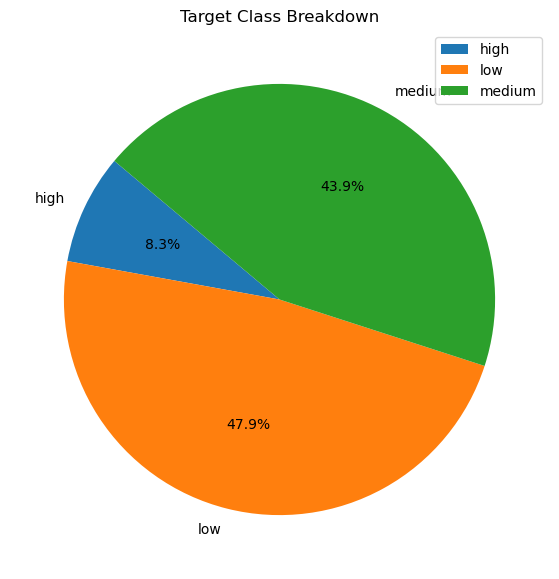

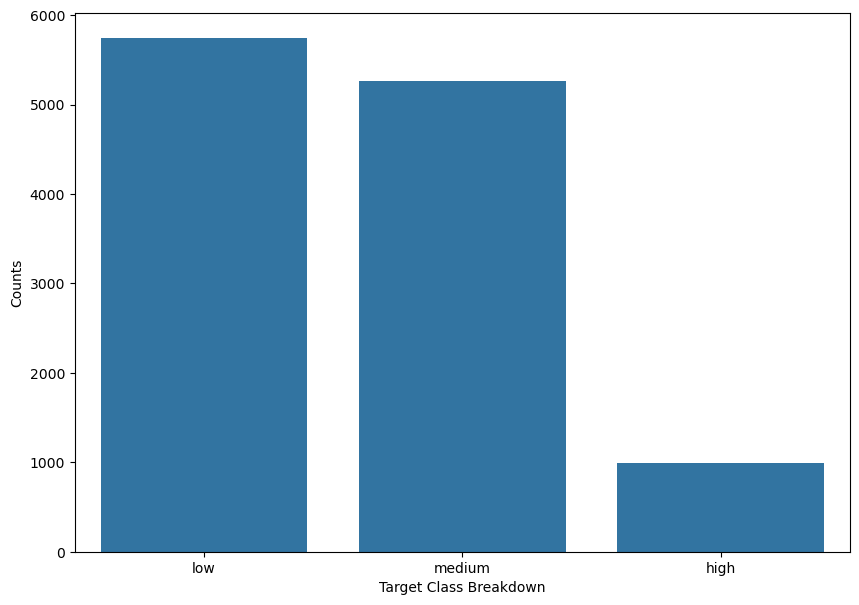

In [6]:
check_class_imbalance(df["salary"])

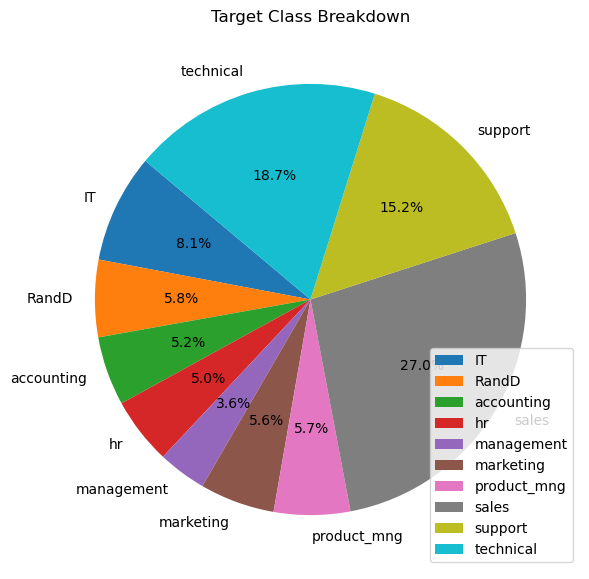

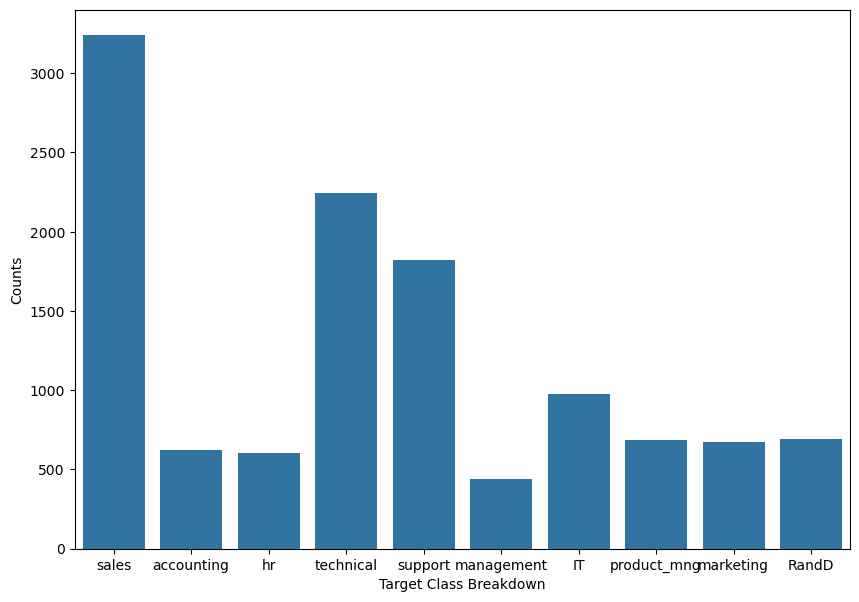

In [7]:
check_class_imbalance(df["Department"])

In [8]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [10]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [9]:
numeric_types = df.select_dtypes(exclude=["object"])
categorical_types = df.select_dtypes(include=["object"])

In [12]:
heat_map_df = df.copy()
heat_map_df["salary"] = heat_map_df["salary"].apply(lambda x: 0 if x == "low" else 1 if x == "medium" else 2)

# Heat Map

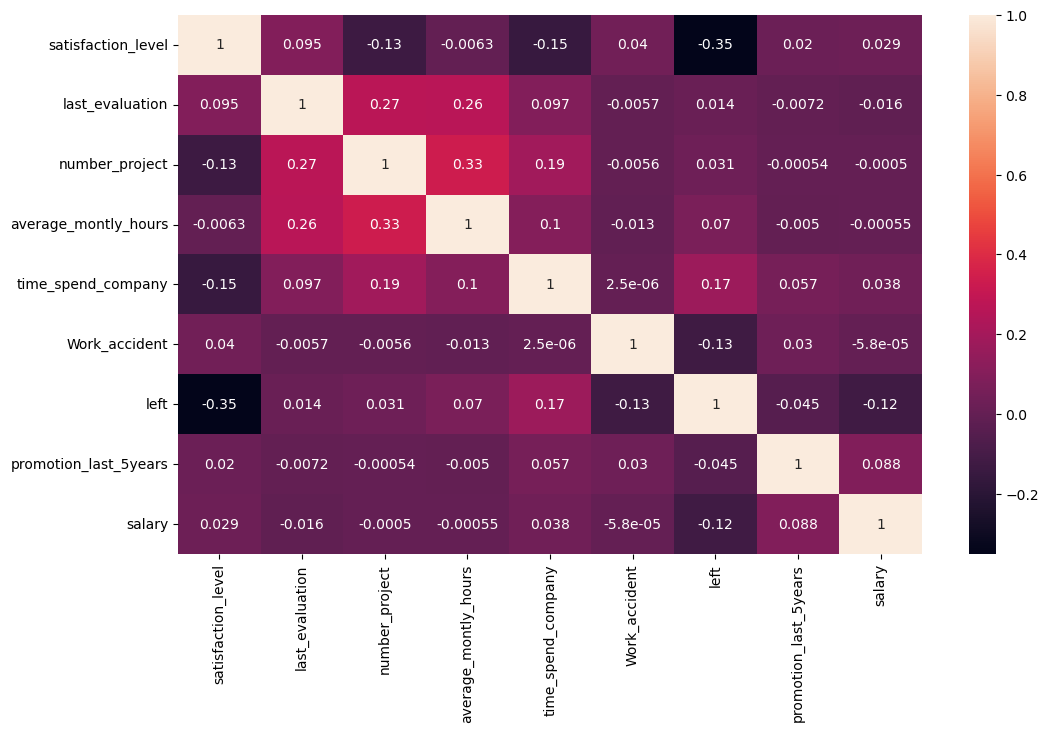

In [13]:
relations = heat_map_df.select_dtypes(exclude="object").corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

# Distributions

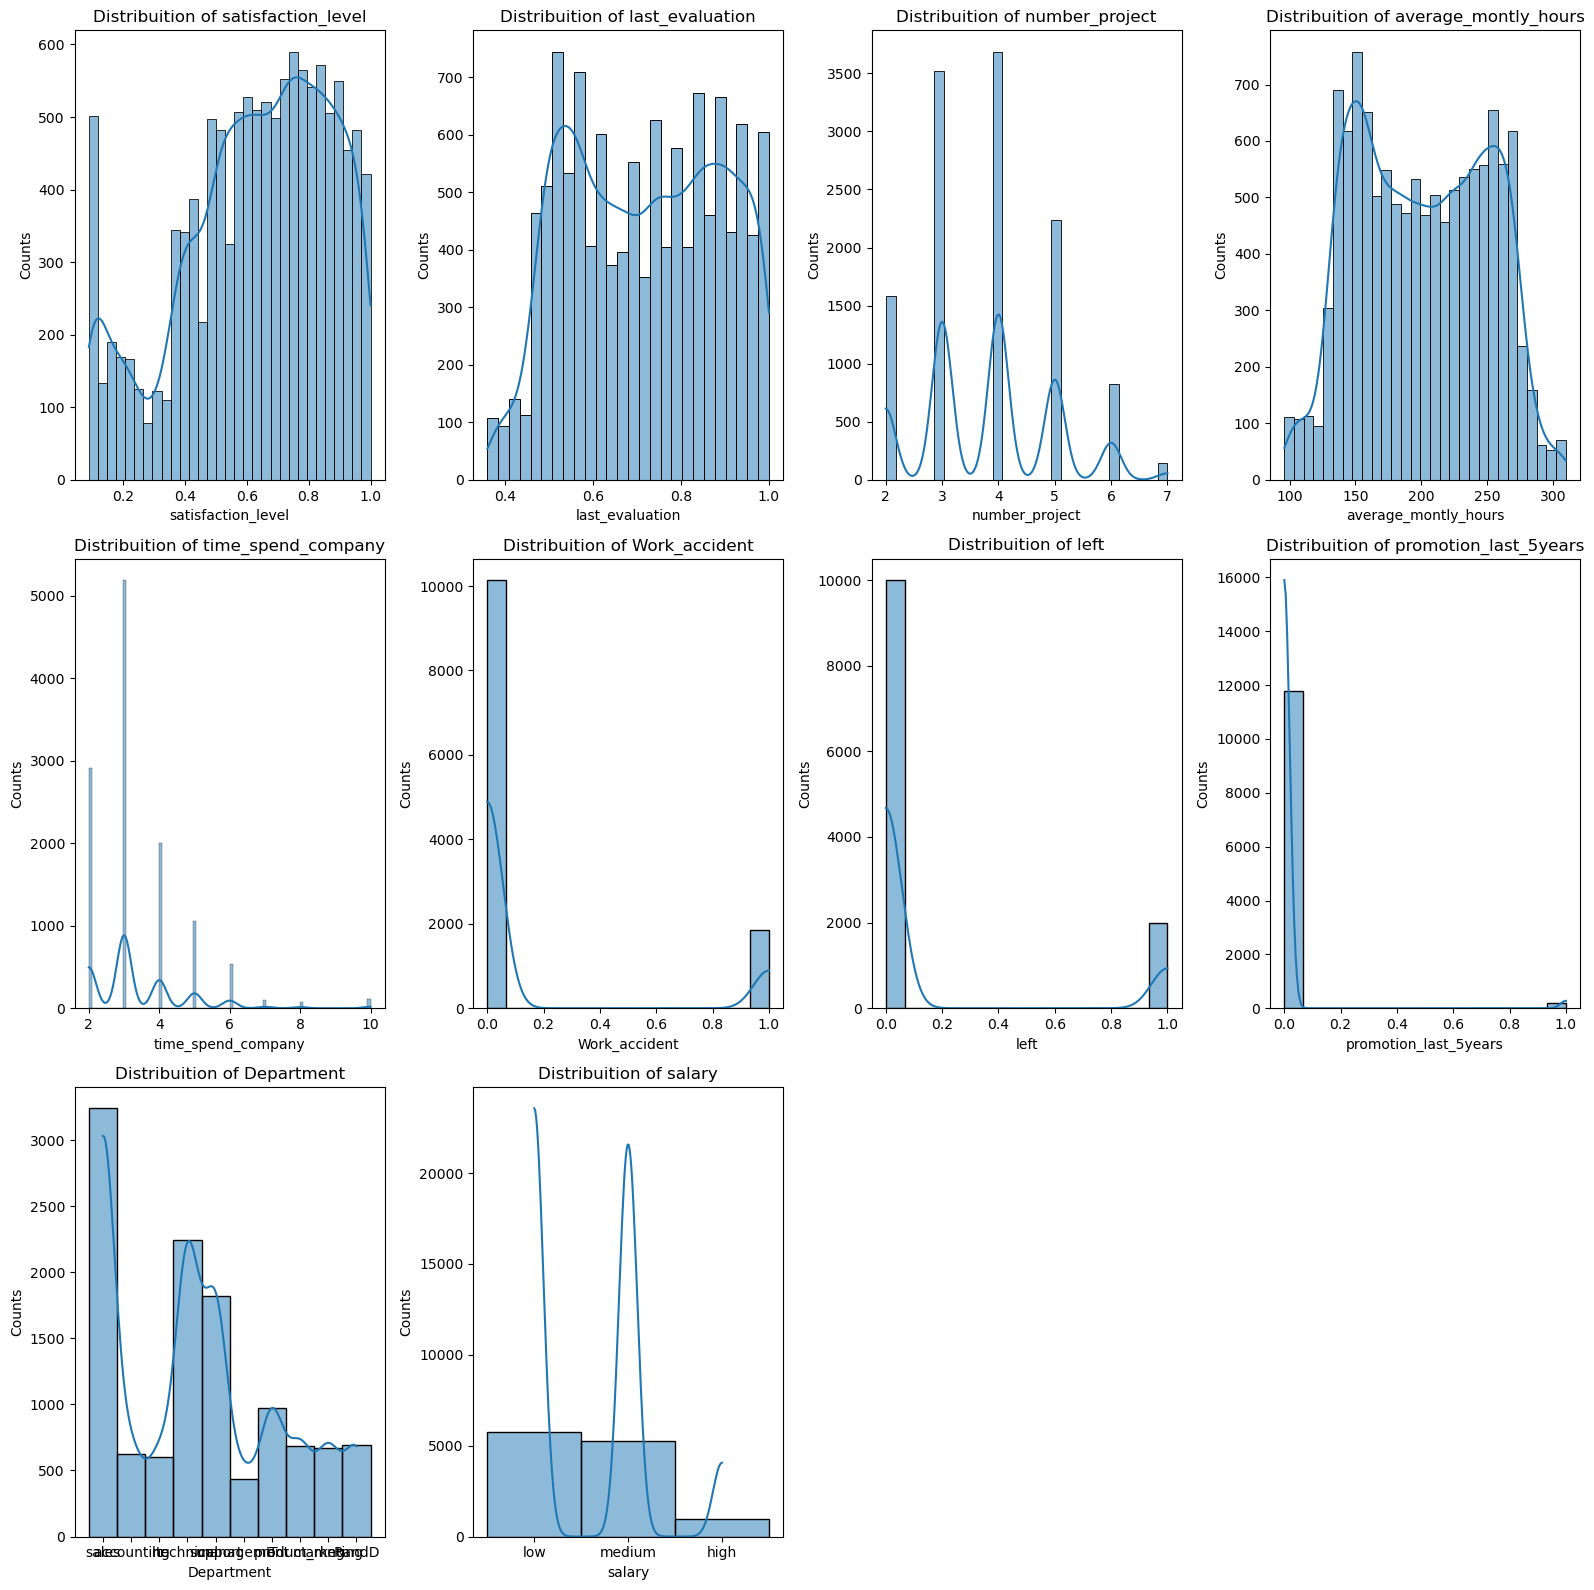

In [15]:
plot_distribution(df, "hist")

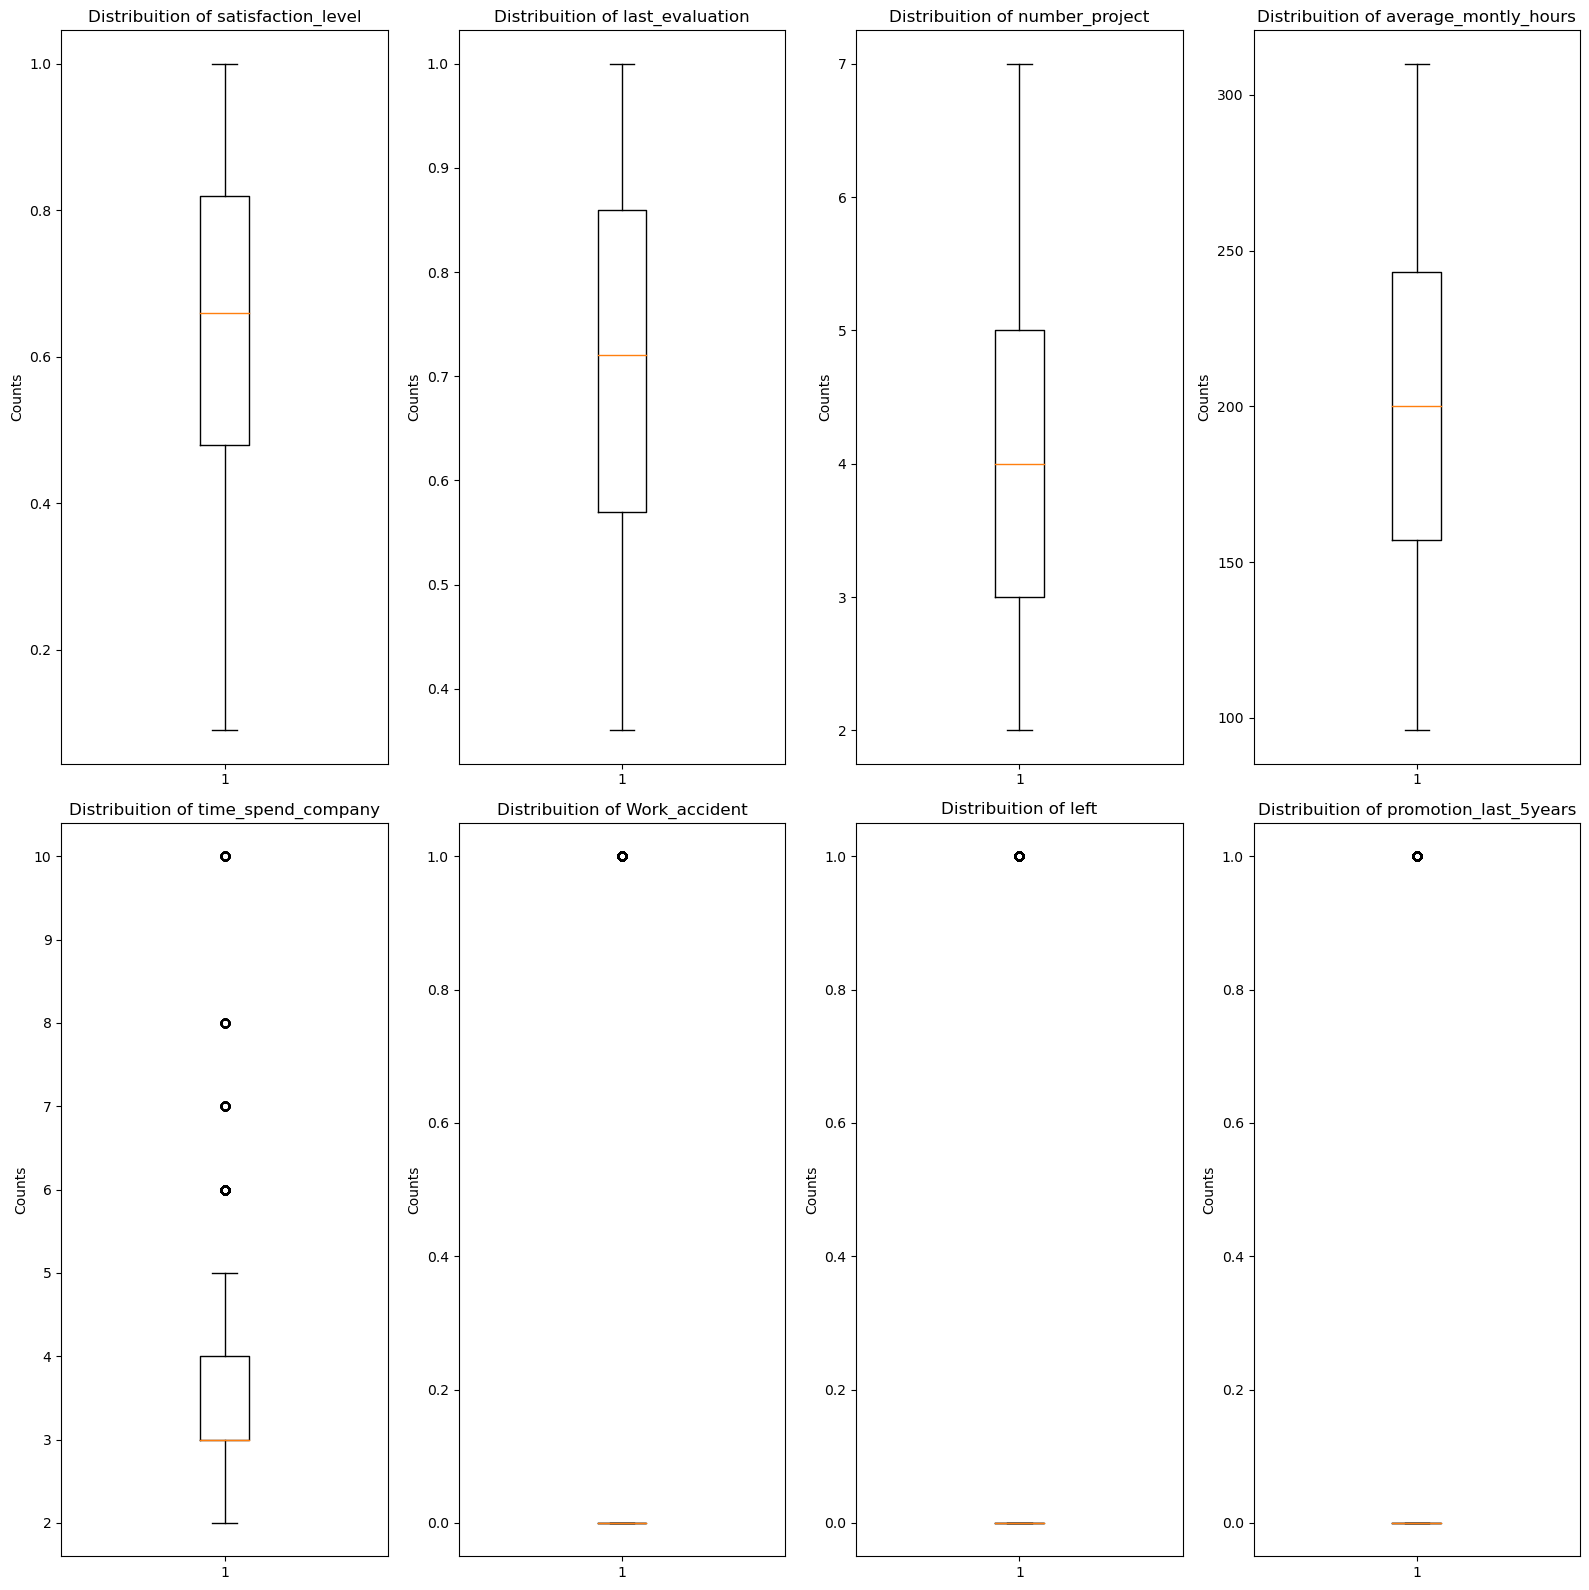

In [17]:
plot_distribution(numeric_types, "box")